In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

res_1_df = pd.read_csv('results_1.1.csv')
os.makedirs('plots', exist_ok=True)


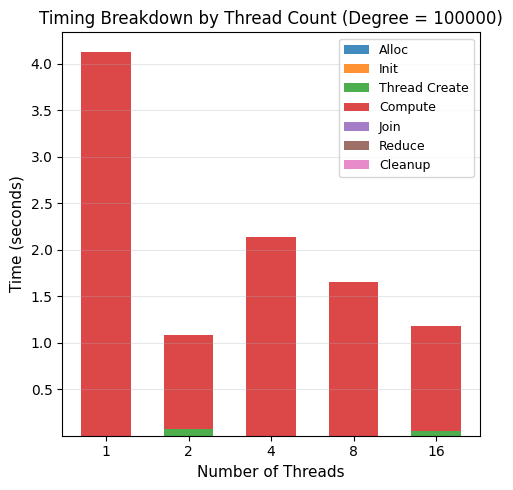

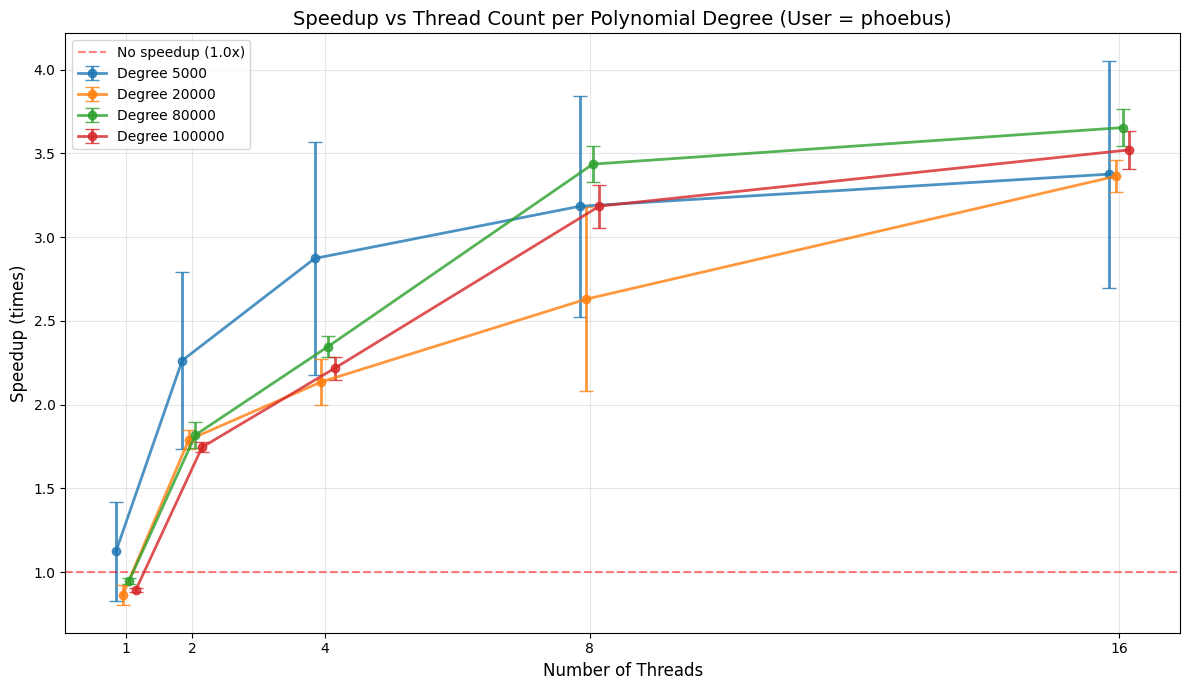

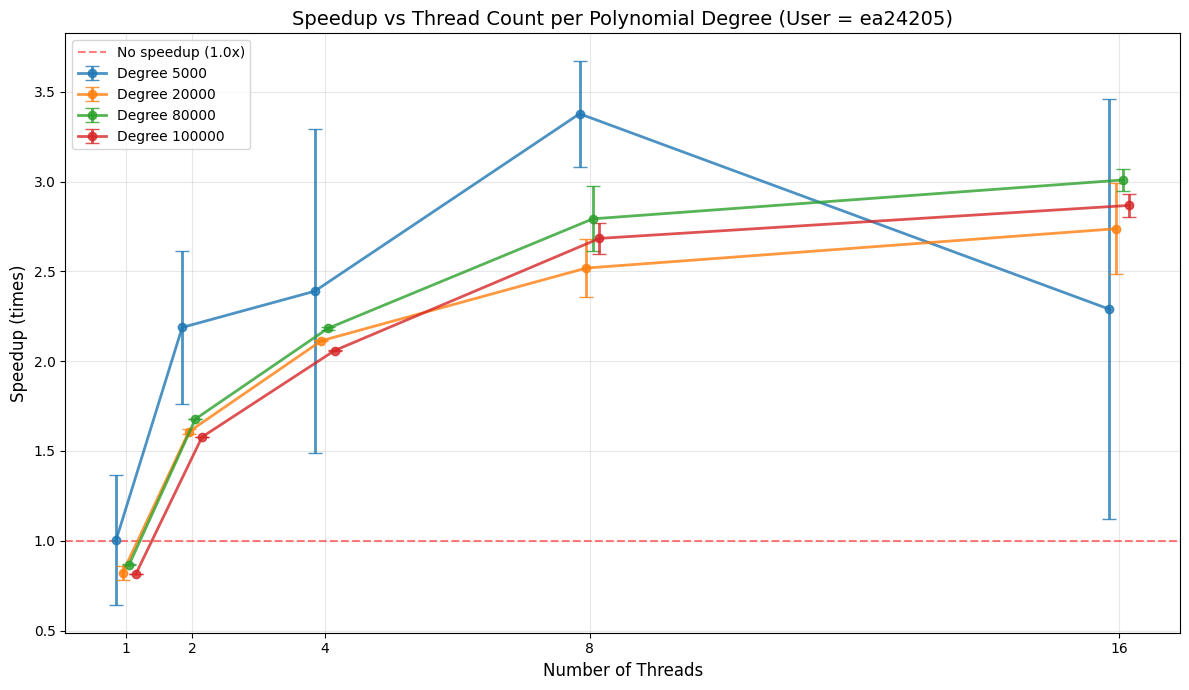

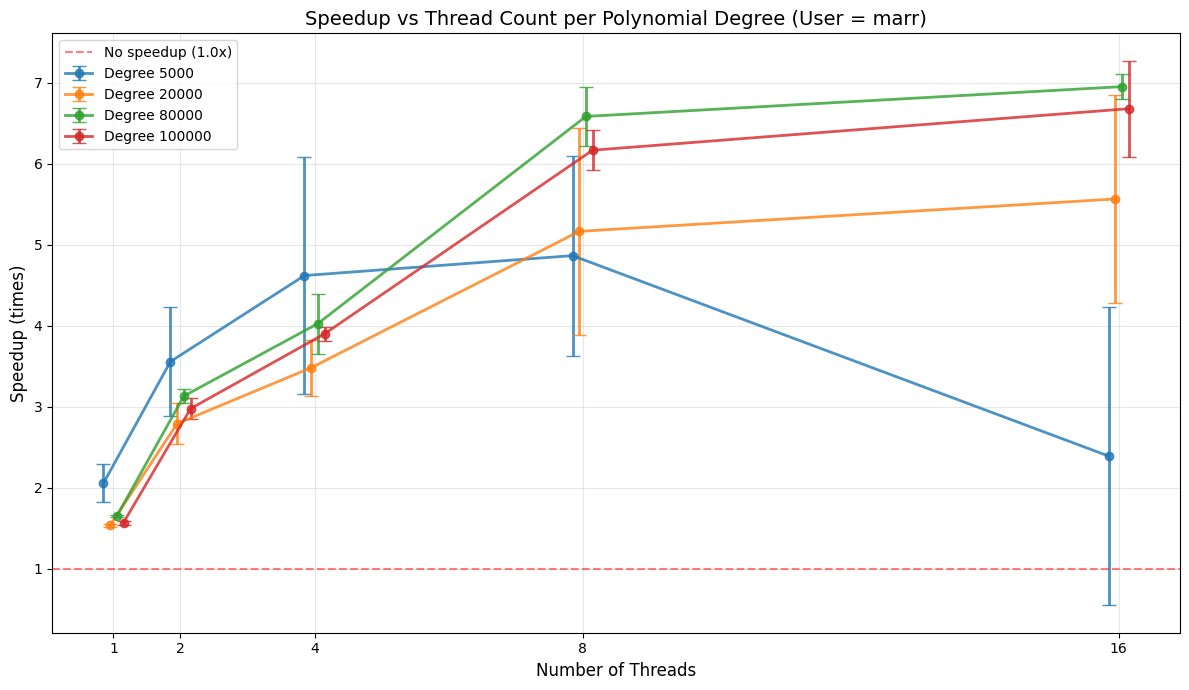


Unique users: ['phoebus', 'ea24205', 'marr']
Plots saved for each user.


In [8]:
# Visualize timing breakdown for parallel executions (if components are available)
parallel_data = res_1_df[res_1_df['threads'] != 'sequential'].copy()
# Exclude time_verify from the breakdown plot
expected_components = ['time_alloc', 'time_init', 'time_thread_create', 'time_compute', 'time_join', 'time_reduce', 'time_cleanup']
available_components = [c for c in expected_components if c in res_1_df.columns]

if len(available_components) > 0:
    # Use the largest degree value for the breakdown plot
    example_degree = parallel_data['degree'].max()
    example_data = parallel_data[parallel_data['degree'] == example_degree].copy()
    example_data = example_data.groupby('threads').mean(numeric_only=True).reset_index()
    
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Map components to labels
    component_labels = {
        'time_alloc': 'Alloc',
        'time_init': 'Init',
        'time_thread_create': 'Thread Create',
        'time_compute': 'Compute',
        'time_join': 'Join',
        'time_reduce': 'Reduce',
        'time_cleanup': 'Cleanup'
    }
    
    # Get actual thread counts and create x positions
    thread_counts = sorted([int(t) for t in example_data['threads'].values])
    x_positions = np.arange(len(thread_counts))
    
    bottom = np.zeros(len(example_data))
    for component in available_components:
        label = component_labels.get(component, component)
        ax.bar(x_positions, example_data[component], bottom=bottom, label=label, alpha=0.85, width=0.6)
        bottom += example_data[component].values
    
    ax.set_xlabel('Number of Threads', fontsize=11)
    ax.set_ylabel('Time (seconds)', fontsize=11)
    ax.set_title(f'Timing Breakdown by Thread Count (Degree = {int(example_degree)})', fontsize=12)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(thread_counts)
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(f'plots/timing_breakdown_degree_{int(example_degree)}.png', dpi=300)
    plt.show()

# Calculate speedup (sequential time / parallel time)
# Exclude verification time from total time for fair comparison
speedup_data = []

for degree in res_1_df['degree'].unique():
    degree_data = res_1_df[res_1_df['degree'] == degree]
    
    # Get sequential baseline for THIS SPECIFIC DEGREE (without verification time)
    seq_data = degree_data[degree_data['threads'] == 'sequential']
    if 'time_verify' in seq_data.columns:
        seq_times = (seq_data['time_total'] - seq_data['time_verify']).values
    else:
        seq_times = seq_data['time_total'].values
    
    if len(seq_times) > 0:
        seq_time = np.mean(seq_times)
        
        # Calculate speedup for each parallel execution at this degree
        for _, row in degree_data[degree_data['threads'] != 'sequential'].iterrows():
            # Exclude verification time from parallel execution too
            if 'time_verify' in row.index:
                par_time = row['time_total'] - row['time_verify']
            else:
                par_time = row['time_total']
            speedup = seq_time / par_time
            speedup_data.append({
                'degree': degree,
                'threads': int(row['threads']),
                'speedup': speedup,
                'user': row['user']
            })

speedup_df = pd.DataFrame(speedup_data)

# Get unique users
unique_users = speedup_df['user'].unique()

# Create plots for each user
for user in unique_users:
    user_data = speedup_df[speedup_df['user'] == user]
    speedup_stats = user_data.groupby(['degree', 'threads'])['speedup'].agg(['mean', 'std']).reset_index()
    
    # Plot speedup with error bars and jitter
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Define jitter offset for each degree
    unique_degrees = sorted(speedup_stats['degree'].unique())
    jitter_offset = np.linspace(-0.15, 0.15, len(unique_degrees))
    
    for idx, degree in enumerate(unique_degrees):
        degree_stats = speedup_stats[speedup_stats['degree'] == degree].copy()
        # Add jitter to x positions
        x_jitter = degree_stats['threads'] + jitter_offset[idx]
        ax.errorbar(x_jitter, degree_stats['mean'], 
                    yerr=degree_stats['std'], marker='o', label=f'Degree {int(degree)}', 
                    linewidth=2, capsize=5, linestyle='-', alpha=0.8)
    
    ax.set_xlabel('Number of Threads', fontsize=12)
    ax.set_ylabel('Speedup (times)', fontsize=12)
    ax.set_title(f'Speedup vs Thread Count per Polynomial Degree (User = {user})', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(sorted(speedup_stats['threads'].unique()))
    ax.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='No speedup (1.0x)')
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(f'plots/speedup_per_degree_{user}.png', dpi=300)
    plt.show()

print(f"\nUnique users: {list(unique_users)}")
print(f"Plots saved for each user.")